In [1]:
import os 

output_optim_root = os.environ["DATA"] + "/08_XAI/03.01_SAScore_counterfactuals/"
ChEMBL_path = os.environ["DATA"] + "/00_datasets/ChEMBL25/complete_ChEMBL.smi"

SAScore_threshold = 4.4

In [2]:
from xaimol import generate_black_box_function
from evomol.evaluation import SAScoreEvaluationStrategy




In [3]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CC[C@]2(CC1)C(=C)CC[C@H]2C(C)C")

4.9603998569984125

In [4]:
SAScoreEvaluationStrategy().eval_smi("C1=CCC2(CC1)C(=C)CCC2C(C)C")

4.6664805418446385

In [5]:
SAScoreEvaluationStrategy().eval_smi("C1=CC[C@]2(CC1)C(=C)CC[C@H]2C(C)C")

4.6664805418446385

In [6]:
SAScoreEvaluationStrategy().eval_smi("C1=CCC2(CC1)C(=C)CC(C(C)C)C2")

4.826613086223338

In [7]:
SAScoreEvaluationStrategy().eval_smi("C1=CCC2(CC1)CC(=C)C(C(C)C)C2")

4.8328829087085445

In [8]:
SAScoreEvaluationStrategy().eval_smi("C1=CCC2(CC1)C(=C)CCC2")


4.398868497366716

In [9]:
SAScoreEvaluationStrategy().eval_smi("C1=CCC2(CC1)CCC(C(C)C)C2")

4.329350628918403

In [10]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CCC2(CC1)CCCC2")

3.8737844125469767

In [11]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CCC2(CC1)CCC(C(C)C)C2")

4.7090700149395115

In [12]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CCC2(CC1)CC=C(C(C)C)C2")

4.811392007895382

In [13]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CCC2(CC1)C=CC(C(C)C)=C2")

5.070041458444832

In [14]:
SAScoreEvaluationStrategy().eval_smi("C#CC1CCC2(CC1)C(=C)CCCC2C(C)C")

4.437667159031156

In [15]:
SAScoreEvaluationStrategy().eval_smi("C#CC1CCC2(CC1)C(=C)CCC2C(C)C")

4.50594342837586

In [16]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CCC2(CC1)C(C)CCCC2C(C)C")

4.869310982814671

In [17]:
SAScoreEvaluationStrategy().eval_smi("C#CC1CCC2(CC1)C(C)CCCC2C(C)C")

4.478427560276828

In [18]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CCCCC1C(=C)CCCC(C)C")

3.9082483994145445

In [19]:
SAScoreEvaluationStrategy().eval_smi("C#CC1=CCC(C(=C)CCCC(C)C)CC1")

3.7263099378760822

In [20]:
SAScoreEvaluationStrategy().eval_smi("N#CC1=CC[C@]2(CC1)C(=C)CC[C@H]2C(C)C")

4.8057068500054045

In [21]:
class NormalizedSAScoreStrategy(SAScoreEvaluationStrategy):
    
    def evaluate_individual(self, ind, ind_to_replace_idx=None):
        normalized_value = super().evaluate_individual(ind)[0]/10
        return normalized_value, [normalized_value]

black_box_classifier = generate_black_box_function(NormalizedSAScoreStrategy(), decision_frontier=0.44,
                                                   flip_frontier=False)

In [22]:
import numpy as np
from rdkit.Chem.rdmolops import RemoveStereochemistry
from rdkit.Chem import MolFromSmiles, MolToSmiles

def load_dataset_sample(path, sample_size, random_seed=42):
    np.random.seed(random_seed)
    
    smiles_list = []
    
    # Reading all SMILES
    with open(path, "r") as f:
        for row in f.readlines():
            smiles_list.append(row.split()[0])

    # Random selection of sample
    samples_list = list(np.random.choice(smiles_list, sample_size))
    
    # Removing stereochemistry for sampled molecules
#     for i in range(len(samples_list)):
#         mol = MolFromSmiles(samples_list[i])
#         RemoveStereochemistry(mol)
#         samples_list[i] = MolToSmiles(mol)
        
    return samples_list
        

In [23]:
smiles_sample = load_dataset_sample(ChEMBL_path, 500)

In [24]:
def study_samples_black_box(black_box_classifier, smiles_samples):
    
    positive_samples = []
    negative_samples = []
    
    for smi in smiles_sample:
        positive_samples.append(smi) if black_box_classifier.assess_class(smi) == "positive" else negative_samples.append(smi)
        
    return positive_samples, negative_samples
    

In [25]:
positive_samples, negative_samples = study_samples_black_box(black_box_classifier, smiles_sample)

In [26]:
print("# positive : " + str(len(positive_samples)))
print("# negative : " + str(len(negative_samples)))

# positive : 36
# negative : 464


In [27]:
positive_samples[8]

'C#CC1=CC[C@]2(CC1)C(=C)CC[C@H]2C(C)C'

In [28]:
from rdkit.Chem.rdmolops import Kekulize, RemoveStereochemistry
from rdkit.Chem import MolToSmiles, MolFromSmiles

def f(smi):
    mol = MolFromSmiles(smi)
    Kekulize(mol)
    RemoveStereochemistry(mol)
    return MolToSmiles(mol)


In [29]:
f("CC(=O)O[C@H]1[C@@H](C)C[C@]2(OC(=O)c3ccccc3)C(=O)/C(C)=C/[C@H]3[C@H](C/C=C(/C)[C@H](O)[C@H]12)C3(C)C")

'CC(=O)OC1C(C)CC2(OC(=O)c3ccccc3)C(=O)C(C)=CC3C(CC=C(C)C(O)C12)C3(C)C'

### Generation of counterfactual for positive (non synthesizable) samples (TANIMOTO + ECFP4)

In [30]:
from xaimol import generate_counterfactuals, get_distance_function, get_class_objective_function
from evomol.evaluation_dft import smi_to_filename
from os.path import join
from IPython.utils import io

paths = []
distance_functions = []

samples_selection = positive_samples[:10]

for i, smi in enumerate(samples_selection):
    path = join(output_optim_root, "gen_counterfactuals", str(i))
    paths.append(path)
    dist_function = get_distance_function("tanimoto_ecfp4", smi)
    distance_functions.append(dist_function)
    
    objective_function = {
        "type": "mean",
        "functions": [
            dist_function,
            get_class_objective_function(black_box_classifier, smi)
        ],
    }
    
#     with io.capture_output() as captured:
#         generate_counterfactuals(objective_function, smi, path, 
#                                  optimization_parameters={"max_steps": 100, "mutation_max_depth": 1},
#                                  action_space_parameters={"max_heavy_atoms": 60, "remove_group": True})

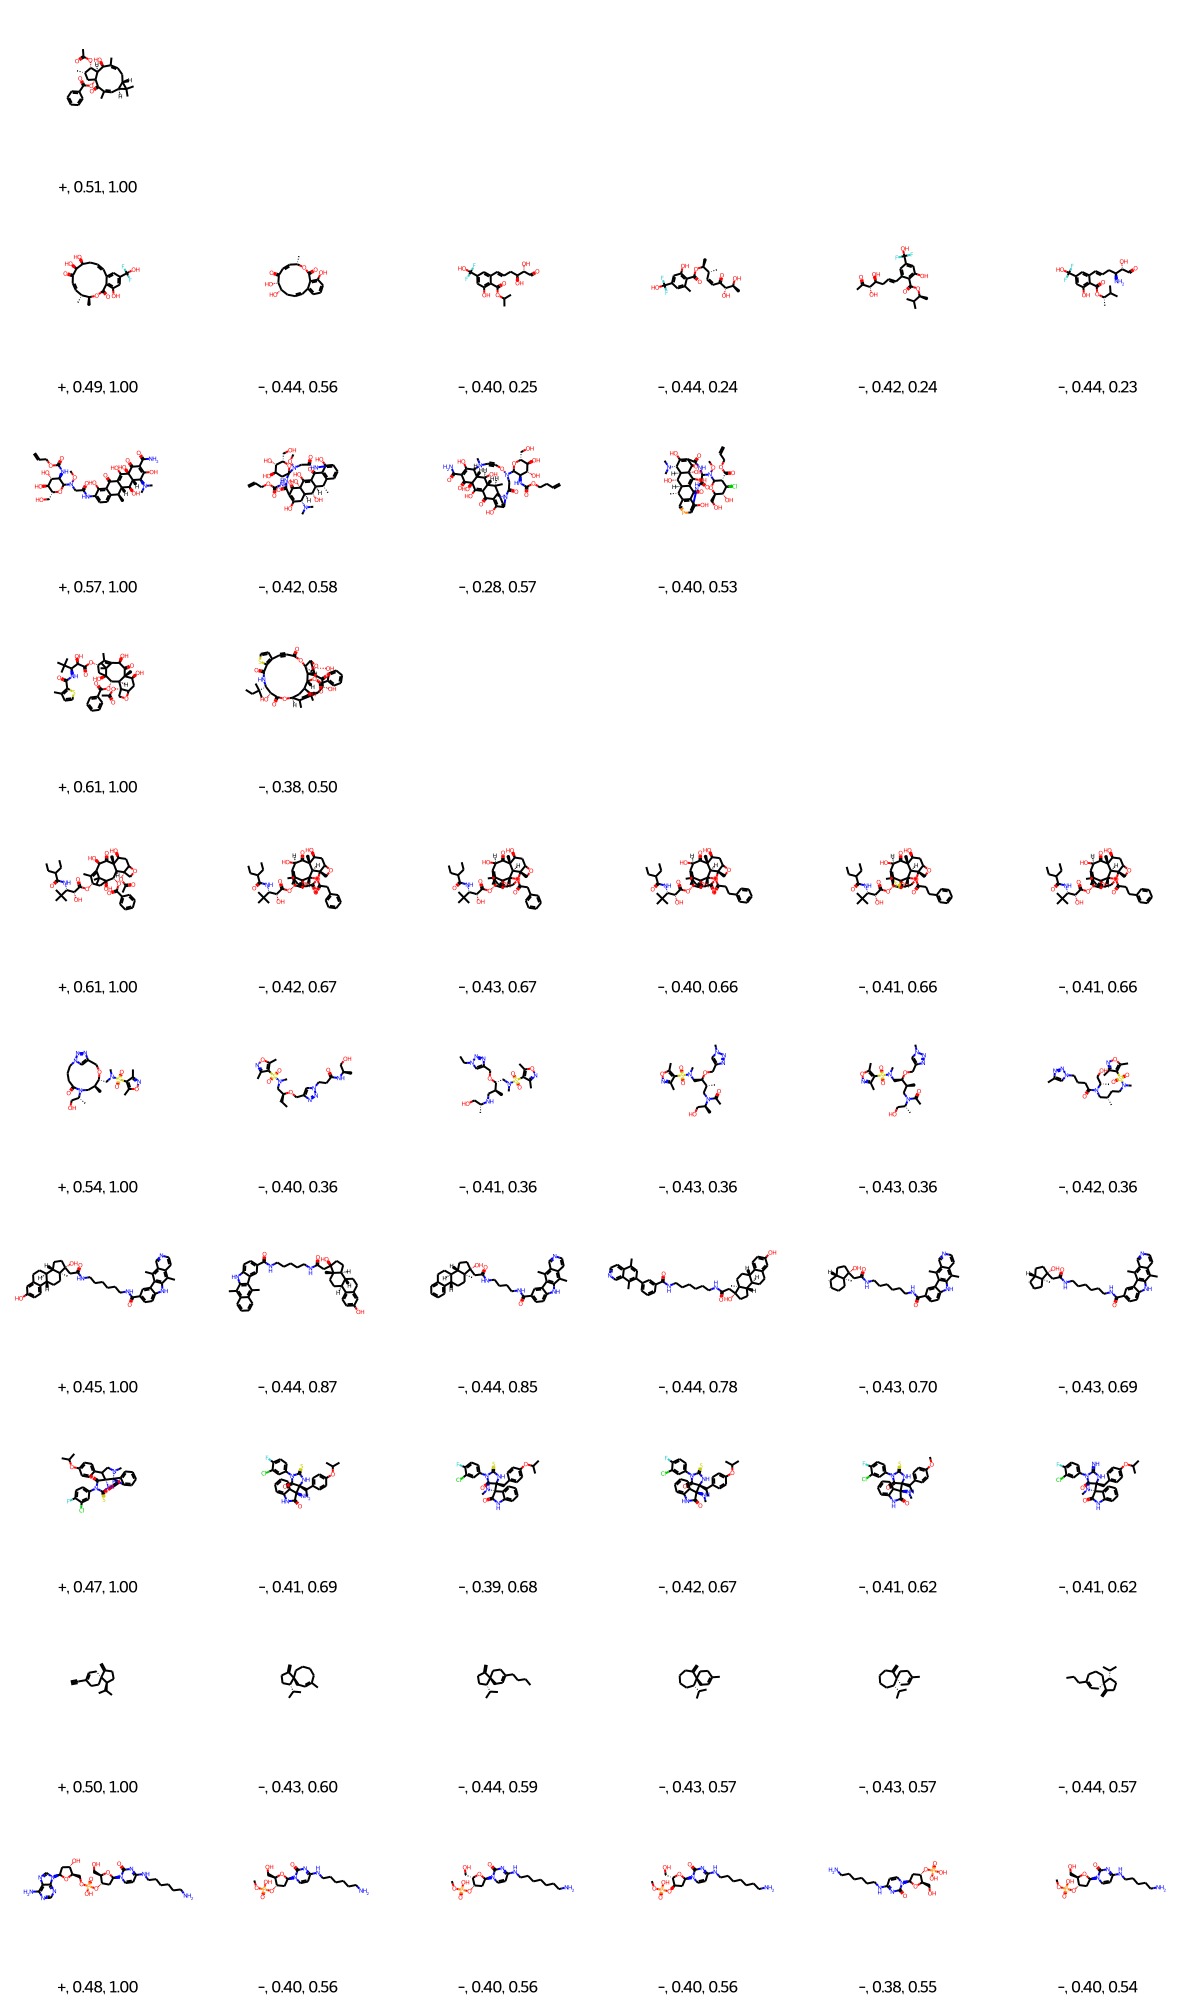

In [31]:
from xaimol.visualization import plot_counterfactuals

plot_counterfactuals(samples_selection, paths, black_box_classifier, distance_functions=distance_functions,
                     n_counterfactuals=5)


### Generation of counterfactual for positive (non synthesizable) samples (# perturbations)

In [32]:
from xaimol import generate_counterfactuals, get_distance_function, get_class_objective_function
from evomol.evaluation_dft import smi_to_filename
from os.path import join
from IPython.utils import io

paths = []
distance_functions = []

samples_selection = positive_samples[:10]

for i, smi in enumerate(samples_selection):
    path = join(output_optim_root, "gen_counterfactuals_n_perturb", str(i))
    paths.append(path)
    dist_function = get_distance_function("number_mutations_penalty", smi)
    distance_functions.append(dist_function)
    
    objective_function = {
        "type": "linear_combination",
        "functions": [
            dist_function,
            get_class_objective_function(black_box_classifier, smi)
        ],
        "coef": [1, 1]
    }
    
#     with io.capture_output() as captured:
#         generate_counterfactuals(objective_function, smi, path, 
#                                  optimization_parameters={"max_steps": 100, "mutation_max_depth": 1},
#                                  action_space_parameters={"max_heavy_atoms": 60, "remove_group": True})

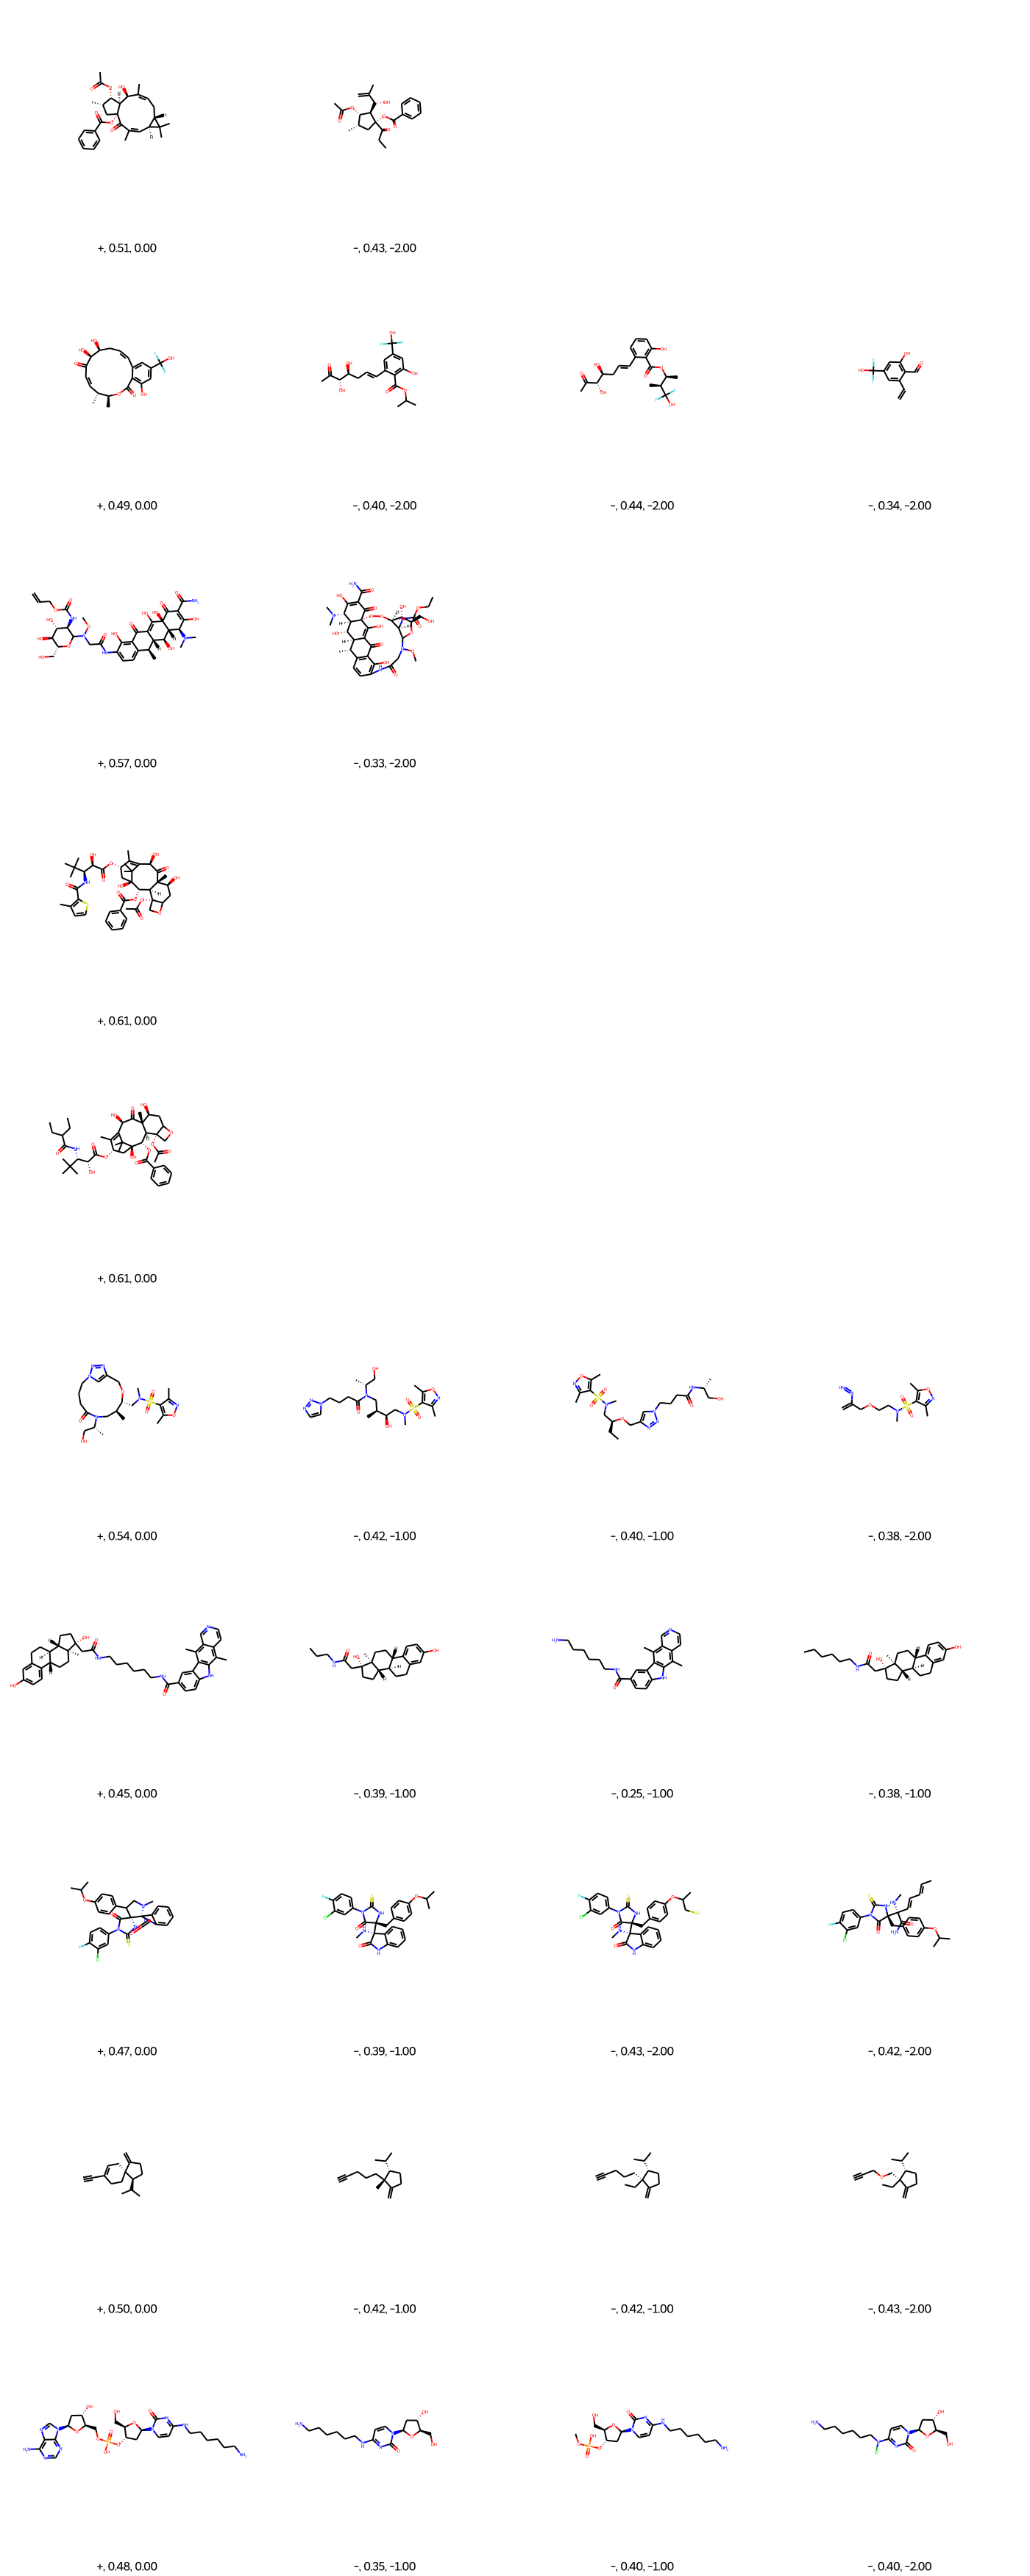

In [33]:
plot_counterfactuals(samples_selection, paths, black_box_classifier, distance_functions=distance_functions,
                     n_counterfactuals=3, mol_size=(350, 350))
